# Atrial Fibrillation classification using Deep Learning

In [186]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as transforms 
from torchvision.utils import make_grid
import wfdb # for reading signal files
import os 
import neurokit2 as nk
import pywt 
import glob 
import h5py
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns 
from tqdm.notebook import tqdm

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

## The dataset

The dataset was obtained from the 2017 Physionet AFib challenge, containing $8528$ records (labeled 'A00001' to 'A08527') in MATLAB header files. The contents of these files can be read using Python's WFDB library. Since the data was collected from a handheld ECG device, not all samples are of the same size. The maximum signal length in the dataset is $18,286$ samples, which amounts to $60.95\:\rm{s}$ given that the sampling rate is $300\:\rm{Hz}$. On the otherhand, the minimum signal length is $2,714$, which is just over $9\:\rm{s}$.

In [150]:
data_list = sorted(glob.glob('./../data/*.mat')) 
data_list = [os.path.splitext(x)[0] for x in data_list] # strips the .mat extensions from the list
#label_list = pd.read_csv('./../data/REFERENCE.csv', header=None, names=['record num', 'diagnosis'])
label_list = pd.read_csv('./../data/REFERENCE.csv', index_col=[0])

'''
Function for generating single sample signals from wfdb file
'''
def sample_record(data, n):
    sample = data[n]
    record = wfdb.rdrecord(sample)
    return record.__dict__['p_signal'].flatten()

'''
Sample wfdb file
'''

print(wfdb.rdrecord('./../data/A00001').__dict__)

{'record_name': 'A00001', 'n_sig': 1, 'fs': 300, 'counter_freq': None, 'base_counter': None, 'sig_len': 9000, 'base_time': datetime.time(5, 5, 15), 'base_date': datetime.date(2000, 5, 1), 'comments': [], 'sig_name': ['ECG'], 'p_signal': array([[-0.127],
       [-0.162],
       [-0.197],
       ...,
       [-0.018],
       [-0.022],
       [-0.021]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['A00001.mat'], 'fmt': ['16'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [24], 'adc_gain': [1000.0], 'baseline': [0], 'units': ['mV'], 'adc_res': [16], 'adc_zero': [0], 'init_value': [-127], 'checksum': [0], 'block_size': [0]}


In [151]:
label_list.head(5)

,record num,diagnosis,label
0,A00001,N,1
1,A00002,N,1
2,A00003,N,1
3,A00004,A,0
4,A00005,A,0


The dataset consists of four kinds heart rhythms (discussions to follow). It is apparent that this is quite an unbalanced dataset, which should be taken into account during training. Furthermore, the diagnosis column should be encoded for training and testing purposes. After label encoding, we have

$$ \{ \rm{A} : 0, \rm{N} : 1, \rm{O} : 2, ~ : 3 \} $$

In [152]:
le = LabelEncoder()
label_list['label'] = le.fit_transform(label_list['diagnosis'].values)
label_list.head(5)

,record num,diagnosis,label
0,A00001,N,1
1,A00002,N,1
2,A00003,N,1
3,A00004,A,0
4,A00005,A,0


In [153]:
#label_list.to_csv('./../data/REFERENCE.csv')

In [154]:
# Simple statistics on diagnosis

label_list_stats = label_list.groupby('diagnosis').agg('count').reset_index()
#label_list_stats.columns = ['diagnosis', 'occurrences']

label_list_stats

,diagnosis,record num,label
0,A,738,738
1,N,5050,5050
2,O,2456,2456
3,~,284,284


In [155]:
# Histogram of signal lengths

label_list_copied = label_list.copy()
label_list_copied['signal length'] = ''

for n in range(len(data_list)):
    record = wfdb.rdrecord(data_list[n])
    sig_len = record.__dict__['sig_len']
    label_list_copied.loc[n, 'signal length'] = sig_len

In [156]:
print('Minimum signal length: ' + str(label_list_copied['signal length'].min()))
print('Maximum signal length: ' + str(label_list_copied['signal length'].max()))

Minimum signal length: 2714
Maximum signal length: 18286


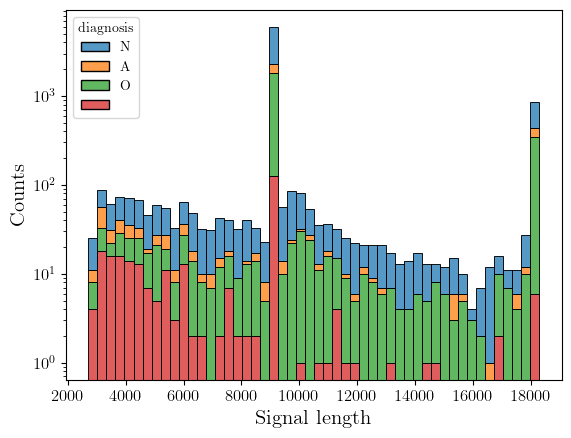

In [157]:
fig, ax = plt.subplots()

sns.histplot(data=label_list_copied, x='signal length', hue='diagnosis', bins=50, multiple='stack')
plt.yscale('log')
plt.xlabel(r'Signal length', fontsize=15)
plt.ylabel(r'Counts', fontsize=15)
plt.show()

Each entry in the dataset contains, apart from the signal array, information such as sample rate (for the signals here is $300\:\rm{Hz}$). The dataset contains four distinct types of ECG recordings (shown below) - (a) normal sinus rhythm (N), (b) afib rhythm (A), (c) other/unclassified rhythm (O) and (d) noise (~). A normal sinus rhythm comprises of distiguishable of P- and T- waves and QRS complexes. Moreover, provided that the recording is being carried out in a steady environment, the time-lapse between successive QRS complexes is constant. The afib rhythm, on the otherhand, apart from unevenly spaced QRS complexes, also display a clear lack of P-waves.

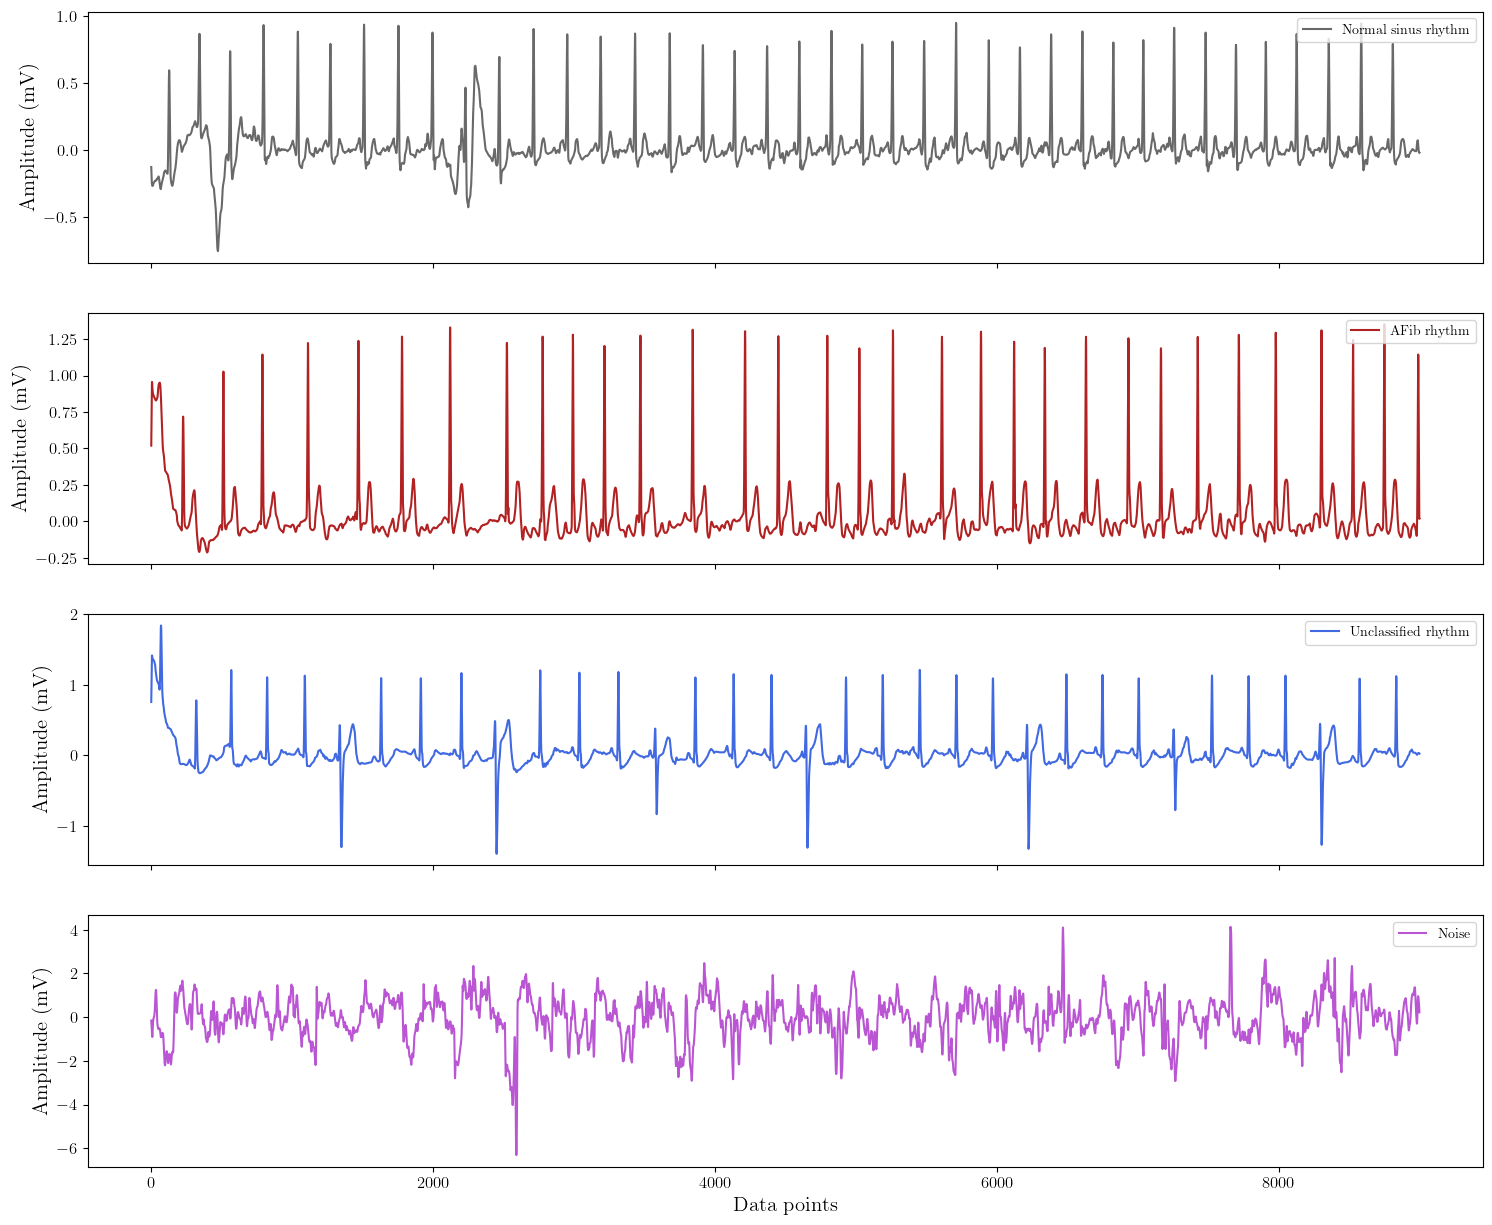

In [158]:
fig, ax = plt.subplots(4, 1, figsize=(18, 15), sharex=True)

color=['dimgray', 'firebrick', 'royalblue', 'mediumorchid']

ax[0].plot(sample_record(data_list, 0), label='Normal sinus rhythm', color=color[0])
ax[0].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[0].legend(loc='upper right')
ax[1].plot(sample_record(data_list, 3), label='AFib rhythm', color=color[1])
ax[1].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[1].legend(loc='upper right')
ax[2].plot(sample_record(data_list, 76), label='Unclassified rhythm', color=color[2])
ax[2].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[2].legend(loc='upper right')
ax[3].plot(sample_record(data_list, 1245), label='Noise', color=color[3])
ax[3].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[3].set_xlabel(r'Data points', fontsize=15)
ax[3].legend(loc='upper right')

plt.show()

## Identifying features in signals

The features that are present in each cycle of a normal sinus rhythm in ECG signals are 
1. a P-wave representing the electrical depolarization of the atria of the heart, shown as a small positive deflection of the baseline.
2. a QRS complex representing the ventricular contraction (systole), consisting of a Q-wave (the first negative deflection), followed by an R- wave (a strong positive deflection from the baseline) and a subsequent negative dip termed as the S-wave.
3. The QRS complex is followed by a T-wave, which is a small positive deflection similar to the P-wave, indicating ventricular repolarization.

A single ECG cycle is shown below

<img src='.\images\ecg.png' class='center' width='600' height='400'>

It can be seen that the time interval between these different P- and T- waves and the QRS complexes also play a big role in determining what an ECG signal looks like. These features can be detected using the Python library *neurokit2*. The signal is first cleaned of noise and passed though nk.ecg_peaks() and nk.ecg_delineate() functions. The nk.ecg_delineate() function can produce a plot of all the ECG cycles stacked with the P- and T- waves and QRS complexes identified. Below, the signal for A00001 is plotted where it can be seen that the different peaks approximately line up when superposed.

In [159]:
def return_peaks(signal):

    signal_trunc = signal[2500:]

    processed_signal = nk.ecg_process(
        signal_trunc,
        sampling_rate=300,
        method='neurokit'
    )

    signal_cleaned = processed_signal[0]['ECG_Clean']
    _, rpeaks = nk.ecg_peaks(signal_cleaned, sampling_rate=300)
    _, wave_peaks = nk.ecg_delineate(
        signal_cleaned,
        rpeaks,
        sampling_rate=300,
        method='peak',
        show=True,
        show_type='peaks'
    )

    return wave_peaks

P-wave peak locations: [181, 419, 654, 899, 1144, 1378, 1606, 1832, 2065, 2292, 2506, 2726, 2952, 3178, 3407, 3632, 3853, 4074, 4294, 4507, 4726, 4948, 5166, 5375, 5591, 5820, 6055, nan]


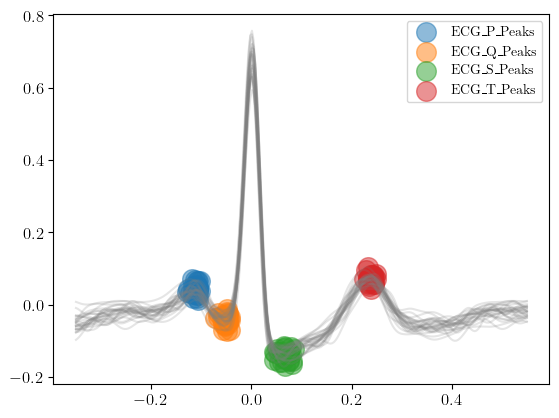

In [160]:
# Record number A00001: normal sinus rhythm

ecg_sig1 = sample_record(data_list,0)

peaks1 = return_peaks(ecg_sig1)

print('P-wave peak locations: ' + str(peaks1['ECG_P_Peaks']))

One the otherhand, when A00004 is plotted using nk.ecg_delineate(), the uneven rhythm means that the ECG cycles cannot be superposed together into a coherent P-QRS-T sequence. Furthermore, a tell-tale sign of atrial fibrillation is the absence of P-waves. In the array wave_peaks2, it can be seen that certain P-waves are shown as NaN.

P-wave peak locations: [210, 440, 694, 889, nan, nan, nan, 2243, 2436, nan, nan, 3326, nan, 3761, nan, nan, 4578, nan, 5147, 5434, 5767, 5949, nan]


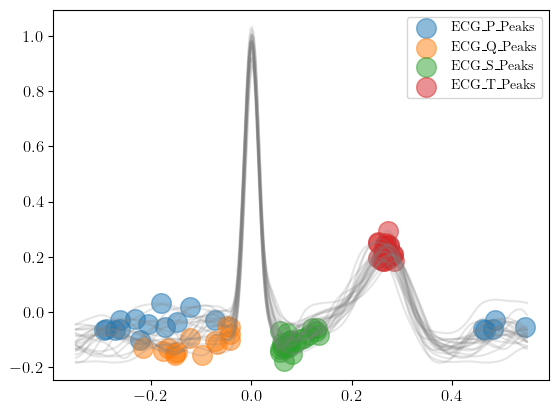

In [161]:
ecg_sig2 = sample_record(data_list,3)

peaks2 = return_peaks(ecg_sig2)

print('P-wave peak locations: ' + str(peaks2['ECG_P_Peaks']))

Although searching for the presence (or lack thereof) of P-waves sounds reasonable, sometimes signals received from handheld ECG devices are not clean, even after processessing, such that these features might become misleading. Moreover, results may vary depending on the particular QRS detection algorithm used. All of these make feature-based detection a very complicated process. One way which streamlines detection is one in which signals can be learned by deep learning algorithms. One popular way to perform this task is to convert $1d$ signals into $2d$ scaleogram images through wavelet transforms and training such images on a convolutional neural network (CNN).

## Wavelet transforms

Before talking about wavelet transforms, one might think why not use Fourier transforms? The reason why Fourier transforms are not preferred can be understood in terms of the uncertainty principle
$$ \Delta t\Delta\omega \geq \frac{1}{2} $$
Hence, by trying to measure the frequency content $\tilde{f}(\omega)$ of a signal precisely, we lose information on the temporal evolution of the signal. Hence, non-stationary signals (such as chirps and ECGs) cannot be modeled well using traditional Fourier transforms. Improvements on the Fourier transform such as short-time Fourier transforms (STFTs) also suffer from resolution issues because of the fixed size of the averaging window function. Wavelet transforms, on the otherhand, not only tell us what frequencies are present in the signal, but also at which time these frequencies occurred - they perform a multiresolution analysis.

Consider a family of orthonormal basis function 
$$ \psi_{jk}(t)=2^{j/2}\psi\left( 2^j t - k \right),\;\;\;\; j,k\in\mathbb{Z} $$
where the function $\psi$ is called an orthonormal wavelet if
$$ \langle \psi_{jk},\psi_{\ell m} \rangle=\int_{-\infty}^\infty dt\:\psi_{jk}(t)\overline{\psi_{\ell m}(t)}=\delta_{j\ell}\delta_{km} $$
Any signal in the time domain can be expressed as a linear combination of these basis functions
$$ f(t)=\sum_{j,k=-\infty}^\infty c_{jk}\psi_{jk}(t) $$
in the form of a *wavelet series*. The *integral wavelet transform* is defined as
$$ \left[ W_\psi f \right](a,b)=\frac{1}{\sqrt{a}}\int_{-\infty}^\infty dt\:f(t)\overline{\psi\left( \frac{t-b}{a} \right)} $$
The coefficients are then given by
$$ c_{jk}=\left[ W_\psi f \right]\left( 2^{-j}, 2^{-j}k \right) $$
where $a=2^{-j}$ and $b=2^{-j}k$ are called dyadic dilation and position respectively.

Here is an example of a non-stationary chirp signal of the following form

$$ X(t)=e^{-(t-t_0)^2/2\sigma^2}\left[ \sin\left( 2\pi f_1(t)t \right) + 0.6\sin\left( 2\pi f_2(t)t \right) \right] $$
where $f_{1,2}(t)$ are two time-dependent frequencies. A $2d$ plot, called a *scaleogram*, can be produced after the CWT operation. In this case, using complex Morlet wavelets
$$ \psi(t)=\frac{1}{\sqrt{\pi B}}e^{-t^2/B}e^{2\pi i C t} $$
where $B$ is the bandwidth and $C$ is the center frequency.

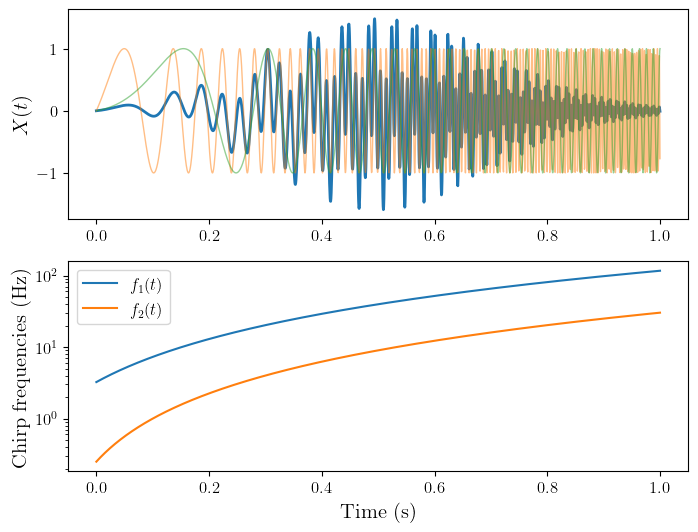

In [162]:
''' 
Example of continuous wavelet transform on a chirp signal
'''
def gaussian(x, x0, sigma):
    return np.exp( -0.5*((x - x0)/sigma)**2 )

def make_chirp(t, t0, a):
    freq = (a*(t + t0))**2
    chirp = np.sin(2*np.pi*freq*t)
    return chirp, freq 

t = np.linspace(0, 1, 2000)
chirp1, freq1 = make_chirp(t, 0.2, 9)
chirp2, freq2 = make_chirp(t, 0.1, 5)
chirp = chirp1 + 0.6*chirp2 
chirp = chirp*gaussian(t, 0.5, 0.2)

fig, ax = plt.subplots(2, 1, figsize=(8,6))

ax[0].plot(t, chirp, linewidth=2)
ax[0].plot(t, chirp1, linewidth=1, alpha=0.5)
ax[0].plot(t, chirp2, linewidth=1, alpha=0.5)
ax[0].set_ylabel(r'$X(t)$', fontsize=15)

ax[1].plot(t, freq1, label=r'$f_1(t)$')
ax[1].plot(t, freq2, label=r'$f_2(t)$')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'Chirp frequencies (Hz)', fontsize=15)
ax[1].set_xlabel(r'Time (s)', fontsize=15)
ax[1].legend(fontsize=12)

plt.show()

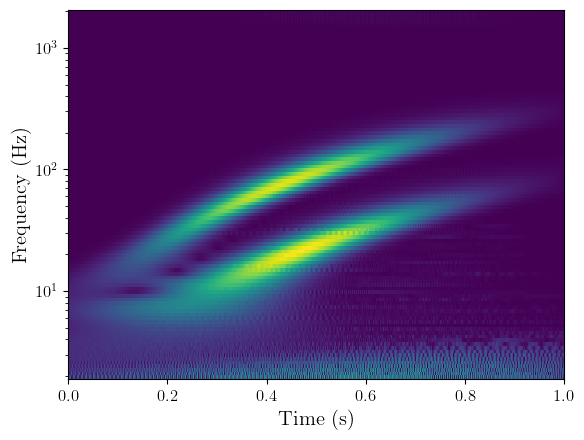

In [163]:
# performing CWT with complex Morlet wavelet

wavelet = 'cmor1.5-1.0'

widths = np.geomspace(1, 1024, num=100) # logarithmic scale for dilation
sampling_period = np.diff(t).mean()
cwmatr, freqs = pywt.cwt(
    chirp,
    widths,
    wavelet,
    sampling_period=sampling_period
)

cwmatr = np.abs(cwmatr)

fig, ax = plt.subplots()
pcm = ax.pcolormesh(t, freqs, cwmatr)
ax.set_yscale('log')
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Frequency (Hz)', fontsize=15)

plt.show()

## Data preprocessing
### Fixing signal lengths

Before performing CWT on the ECG data, the data has to pass through a list of preprocessing steps (packaged in the 'data_preprocessing.py' file). As discussed previously, not all signals last a full minute. Although CWTs can be performed on signals of varying lengths, the images that are fed to the CNN must have a consistent dimensionality. Hence, signals that terminate before $60\:\rm{s}$ have to be padded with zeros. Additionally, it is also convenient to package all of the padded signals and their record numbers into an HDF5 file, which has already been done.

The fix_signal_length() function resizes all the signals to a length of $18,000$ sample points. For signals that are smaller, they are padded with zeros to the right. The few signals which are larger than this, they are terminated at the correct size.

In [164]:
def fix_signal_length(file_list):
    '''
    This function fixes the lengths of the ECG data. The maximum recording length is 60s, which at a sampling rate of 300 Hz, gives a signal length
    of 18,000. Readings that are given by arrays of length less than 18,000 are padded with zeros to the right. 

    The function takes as input a directory of all the .mat and .hea files from which the signals are extracted and flattened. Each of the padded
    array as stored in a 2d array that is returned as output.

    There are a few entries which slightly exceed 60s (hence, have more than 18,000 data points). Such entries have been restricted to array size of
    18,000.
    '''
    data_array = np.zeros((len(file_list), 18000)) # all the different signals are stored along the rows
    sampling_times = np.linspace(0.0, 60.0, 18000) 

    for i in range(len(file_list)):

        record = wfdb.rdrecord(file_list[i]).__dict__
        signal = record['p_signal'].flatten()
        sig_len = record['sig_len']
        
        if sig_len < 18000:
            extra_dim = 18000 - sig_len # extra padding dimensions
            signal_padded = np.pad(signal, (0, extra_dim), 'constant', constant_values=0)
            data_array[i, :] = signal_padded

        elif sig_len == 18000:
            data_array[i, :] = signal # no padding if sig_len = 18000

        elif sig_len > 18000:
             data_array[i, :] = signal[0:18000] # truncate signal length to 18000

    return data_array, sampling_times 

data_array, sampling_times = fix_signal_length(data_list)
print(data_array)
print(f'The shape of the array is {data_array.shape}')

[[-0.127 -0.162 -0.197 ...  0.     0.     0.   ]
 [ 0.128  0.157  0.189 ...  0.     0.     0.   ]
 [ 0.056  0.073  0.085 ... -0.064 -0.036 -0.02 ]
 ...
 [-0.202 -0.235 -0.272 ...  0.     0.     0.   ]
 [-0.227 -0.297 -0.374 ...  0.     0.     0.   ]
 [-0.237 -0.286 -0.338 ...  0.     0.     0.   ]]
The shape of the array is (8528, 18000)


### Signal cleaning and CWT

Like most signals, ECGs contain unwanted noise and other artifacts. One pervasive artifact in ECGs is what is called *baseline wander* where the signal is modulated by a low frequency wave. This occurs due to various factors and is undesirable. Before the signals are processed through a CWT, they are first cleaned through filters. This is done using neurokits nk.ecg_clean() function. The signal_CWT() function in the preprocessing file performs the required CWT on the signals and saves them as $(224\times224\times 3)$ arrays in the 'signal_cwt_images_training' folder.

In [165]:
def signal_CWT(raw_signal, sampling_rate=300, method='neurokit', wavelet='cmor2.5-1.0'):
    clean_signal = nk.ecg_clean(
        raw_signal,
        sampling_rate,
        method
    )
    scales = np.geomspace(1, 750, num=150)
    sampling_period = np.diff(sampling_times).mean()

    cwmat, freqs = pywt.cwt(
        clean_signal,
        scales,
        wavelet=wavelet,
        sampling_period=sampling_period
    )

    return np.abs(cwmat), freqs

In [166]:
_, freqs = signal_CWT(data_array[0,:])

print(freqs)

[299.98333333 286.94681817 274.4768369  262.54876941 251.13906549
 240.22519838 229.78562026 219.79971974 210.24778115 201.11094559
 192.37117374 184.01121021 176.01454951 168.36540341 161.04866981
 154.0499029  147.35528466 140.95159756 134.82619846 128.96699368
 123.36241508 118.00139727 112.87335569 107.9681658  103.27614303
  98.78802368  94.49494661  90.38843579  86.46038352  82.70303444
  79.10897023  75.67109493  72.38262098  69.23705578  66.22818886
  63.35007967  60.59704581  57.96365182  55.44469846  53.03521242
  50.73043654  48.52582038  46.41701125  44.39984561  42.47034088
  40.62468753  38.8592416   37.17051748  35.55518102  34.01004299
  32.53205274  31.1182922   29.76597011  28.47241651  27.23507747
  26.05151005  24.91937747  23.8364445   22.80057305  21.80971795
  20.8619229   19.95531661  19.08810914  18.25858831  17.46511635
  16.70612667  15.98012076  15.28566522  14.62138896  13.98598047
  13.37818521  12.7968032   12.24068657  11.70873737  11.19990532
  10.71318

The scalograms of the ECG signals that were plotted previously are shown here. Rich structures of frequency content now appear on the $2d$ plots as a function of time that would not have been possible to obtain if simply FFTs were considered. Above $20\:\rm{Hz}$, the frequency content becomes rather uniform, without any distinguishing patterns. Some of the interesting phenomena, however, occur in the low-frequency band of $0.5 - 5\:\rm{Hz}$.

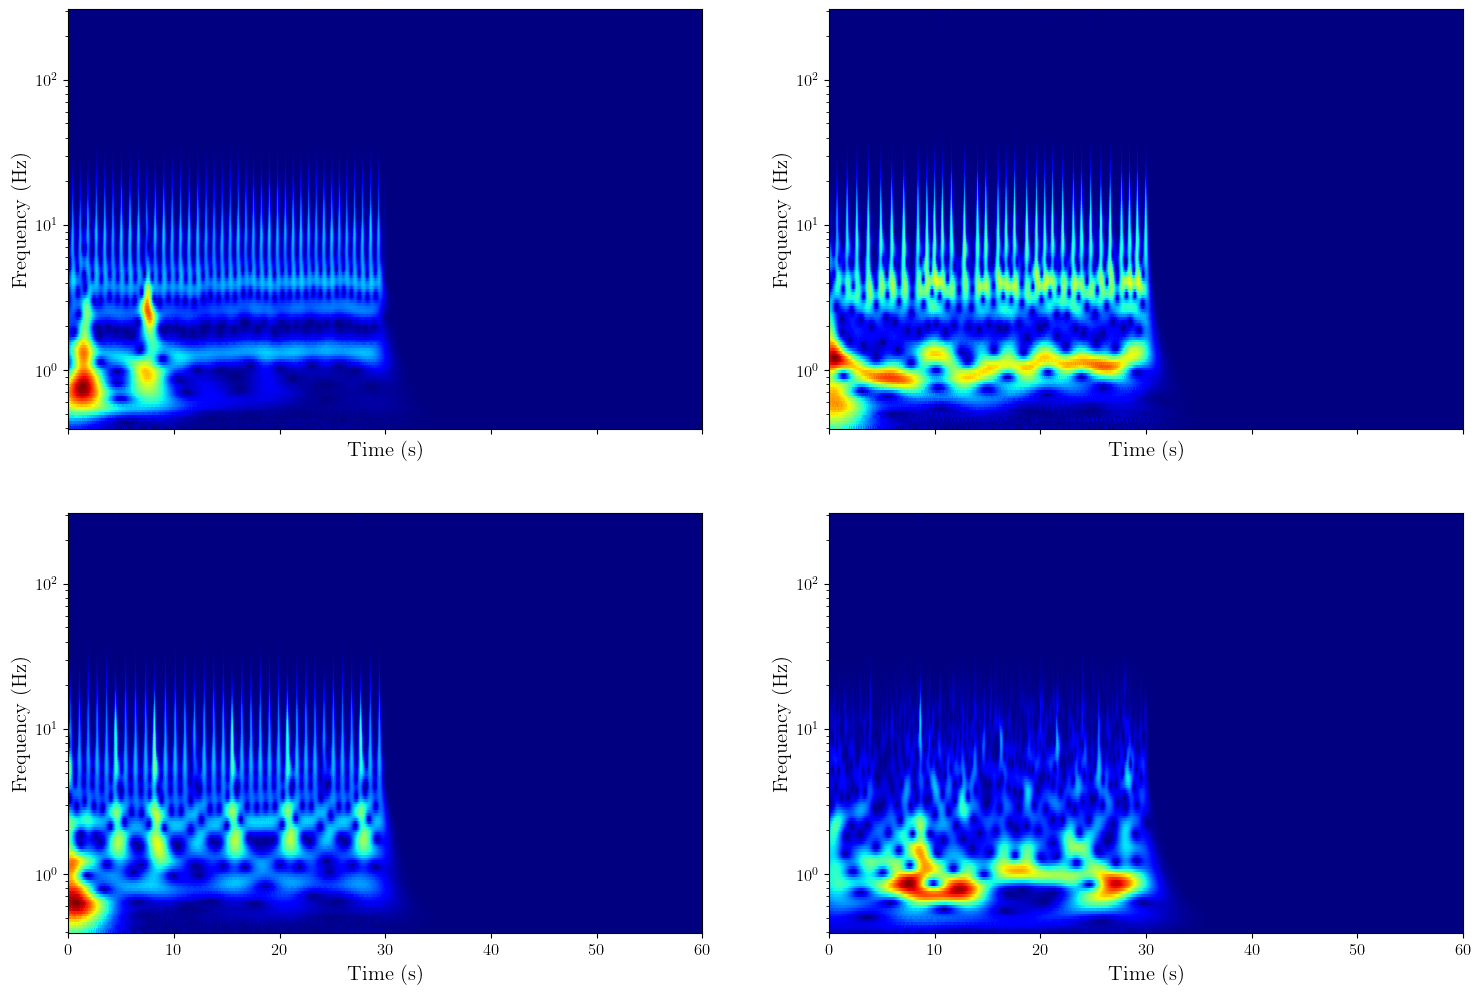

In [167]:
ll = [0, 3, 76, 1245] # previously plotted samples
annot = ['normal', 'afib', 'other', 'noise']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12), sharex=True)

for col, ax in zip(ll, ax.ravel()):
    coeff_mat, freqs = signal_CWT(data_array[col, :])
    pcm = ax.pcolormesh(sampling_times, freqs, coeff_mat, cmap='jet')
    ax.set_xlabel(r'Time (s)', fontsize=15)  
    ax.set_ylabel(r'Frequency (Hz)', fontsize=15)
    ax.set_yscale('log')
  
plt.show()

## Datasets and DataLoaders
Since the PyTorch DataLoader class constructs batches from a Dataset object, a custom ScalogramDataset class is created here. The ScalogramDataset() class has the following arguments
1. annotation_file : the 'REFERENCE.csv' file which contains the record number and diagnosis category for each signal
2. img_dir : the image directory
3. split_index : an array containing indices for train test split since such a split was not done at a directory level
4. transform : transformations on the images

In [168]:
training_img_dir = './../signal_cwt_images_training/'

In [169]:
''' 
Since there is no train/test split of the images, it has to be performed manually before image augmentation is applied.
'''

idx = np.arange(0, 8528)
idx_train, idx_test = train_test_split(idx, test_size=0.2, shuffle=True, random_state=100) # random_state=100 for reproducibility

In [170]:
class ScalogramDataset(Dataset):
    ''' 
    The scalogram dataset is initialized with the REFERENCE.csv file, image directory and a list of 
    suitable transformations on the image dataset.

    In this form, the annotations_file is represented as a directory reference to the REFERENCE.csv file. The split index argument refers to
    the particular train/test split inside the image directory.
    '''
    def __init__(self, annotations_file, img_dir, split_index, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, index_col=[0]).iloc[split_index, :]
        self.img_dir = img_dir 
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_name = self.img_labels.iloc[idx, 0] + '.png'
        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path)[0:3, :, :].float() # by default, the image tensors are uint8; these are converted to floats
        label = self.img_labels.iloc[idx, 2] # the third column contains the encoded diagnoses

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label 

During data augmentation, a major transformation is *normalization* where each pixel in each channel is transformed via
$$ \widetilde{\rm{pixel}}_{\rm{R,G,B}} = \frac{\rm{pixel}_{\rm{R,G,B}} - \mu_{\rm{R,G,B}}}{\sigma_{\rm{R,G,B}}} $$
where $\mu_{\rm{R,G,B}}$ and $\sigma_{\rm{R,G,B}}$ are the means and standard deviations of the pixels in the R, G, B channels. This can be calculated through the pixel_stats() function. This yields
$$ \mu_{\rm{R,G,B}}=\left[ 7.23, 26.71, 162.45 \right] $$
and, 
$$ \sigma_{\rm{R,G,B}}=\left[ 35.71, 66.20, 54.35 \right] $$
The large value of $\mu_{\rm{B}}$ is unsurprising due to the color map chosen to represent the scalograms.

In [171]:
def pixel_stats(annotations_file, img_dir):
    img_labels = annotations_file.iloc[:,0] # dataframe converted into a series object here

    channel_sum = 0
    channel_squared_sum = 0

    for idx in range(len(img_labels)):
        img_file_name = img_labels[idx] + '.png'
        img_path = os.path.join(img_dir, img_file_name)
        img = read_image(img_path)[0:3, :, :].float()

        ''' 
        When the mean and standard deviation of the channels are calculated, the image matrix must be
        converted to the appropriate type using .float(). Otherwise, PyTorch will return an error message.
        '''
        channel_sum += torch.mean(img.float(), dim=[1, 2]) # dim=1,2 refer to the pixel axes only; returns a 1 x 3 tensor
        channel_squared_sum += torch.mean((img**2).float(), dim=[1,2])

    mean = channel_sum/len(img_labels)
    std = torch.sqrt(( channel_squared_sum/len(img_labels) - mean**2 ))

    return mean, std 

pixel_stats(label_list, training_img_dir)

(tensor([  7.2307,  26.7144, 162.4496]), tensor([35.7087, 66.2034, 54.3562]))

In [172]:
# Device configuration: check if CUDA is available
# My local device does not

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

For training, a batch size of $32$ is chosen. For image augmentation, random crop, rotation and flipping are performed only on the training dataset. On both training and validation sets, however, the pixel normalization is performed. Moreover, they are resized to $3\times227\times227$ for training with AlexNet.

In [173]:
batch_size = 32 

img_stats = ((7.2307,  26.7144, 162.4496), (35.7087, 66.2034, 54.3562))
train_transform = transforms.Compose(
    [
        transforms.Resize(size=(227, 227)),
        transforms.RandomCrop(size=(227, 227), padding=4, padding_mode='reflect'),
        transforms.RandomRotation(degrees=(-90, 90)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Normalize(*img_stats, inplace=True)
    ]
)

valid_transform = transforms.Compose(
    [
        transforms.Resize(size=(227, 227)),
        transforms.Normalize(*img_stats, inplace=True)
    ]
)

train_ds = ScalogramDataset(
    training_img_dir + 'REFERENCE.csv',
    training_img_dir,
    idx_train,
    transform=train_transform
)

valid_ds = ScalogramDataset(
    training_img_dir + 'REFERENCE.csv',
    training_img_dir,
    idx_test,
    transform=valid_transform
)

print(f'Size of the train set {len(train_ds)}.')
print(f'Size of the test dataset is {len(valid_ds)}.')

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

Size of the train set 6822.
Size of the test dataset is 1706.


Sample images from training set 


Sample images from validation set 


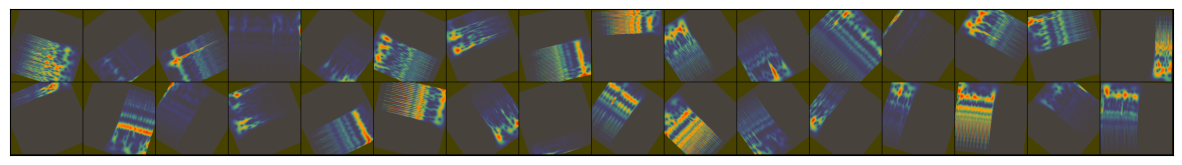

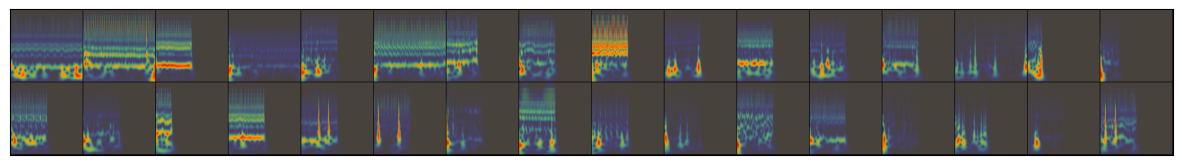

In [174]:
def show_batch(dataloader):
    for image, _ in dataloader:
        fig, ax = plt.subplots(figsize=(15, 8))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(image, nrow=16, normalize=True).permute(1, 2, 0))
        break

print('Sample images from training set ')
show_batch(train_dl)
print('\n')
print('Sample images from validation set ')
show_batch(valid_dl)

## AlexNet

AlexNet is a CNN architecture that was designed by Alex Krizhevsky, Ilya Sutskever and Geoffrey Hinton as part of the $2012$ ImageNet challenge. The AlexNet architecture is shown below, where there is a sequence of five convolutional layers followed by three fully-connected linear layers. The input image is of the form $(3\times227\times227)$. Each convolutional layer has a BatchNorm layer. Moreover, the linear layers have Dropout layers with $p=0.5$. The BatchNorm and Dropout layers are there two minimize overfitting during training.
 
<img src='.\images\alexnet.png' class='center' width='600' height='400'>

All in all, the AlexNet architecture has approximately $60$ million learnable parameters. Hence, training on very large datasets becomes impractical without GPU acceleration. However, the ECG dataset in question is not very large. Nevertheless, training for $150$ epochs on this current CPU (without GPU and other parallelization) takes approximately $6$ hours. A PyTorch class for the AlexNet architecture is shown below where the initial image of shape $\mathcal{B}\times3\times227\times 227$ (where $\mathcal{B}$ is the batch size) is processed through the layers until an output of shape $\mathcal{B}\times 4$ is produced, where $4$ being the number of classes present.

In [175]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # Five convolutional layers

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),          # output shape : 96 x 55 x 55
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)                           # output shape : 96 x 27 x 27
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),         # output shape : 256 x 27 x 27
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)                           # output shape : 256 x 13 x 13
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),        # output shape : 384 x 13 x 13
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),        # output shape : 384 x 13 x 13
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),        # output shape : 256 x 13 x 13
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)                           # output shape : 256 x 6 x 6
        )

        # Three fully connected layers; starting input shape is 256 x 6 x 6 = 9216

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(-1, 9216)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [176]:
model = AlexNet().to(device)
model 

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

Training is performed over $150$ epochs with a learning rate scheduler. The ADAM optimizer is used with default parameters with $\eta_{\rm{max}}=10^{-3}$ and weight decay of $10^{-4}$ and the cross-entropy loss is used on this multiclass dataset.

In [177]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(num_epochs, max_lr, model, train_dl, valid_dl, loss_fn, opt_fun, weight_decay=0):
    '''
    Defining one complete cycle of training and validation over the specified number of epochs
    The function takes in the following parameters
    (1) number of epochs - num_epochs
    (2) maximum learning rate - max_lr
    (3) neural network model
    (4) training and validation/test dataloaders
    (5) regularization in terms of weigh decay (default set to 0)

    '''
    torch.cuda.empty_cache()
    # instantiate optimizer with appropriate weight_decay
    optimizer = opt_fun(model.parameters(), max_lr, weight_decay=weight_decay)
    # setting up one-cycle learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr,
        epochs=num_epochs,
        steps_per_epoch=len(train_dl)
    )
    train_size = len(train_dl.dataset)
    valid_size = len(valid_dl.dataset)
    loss_train = [] # Loss history per epoch during training
    acc_train  = [] # Accuracy history per epoch during training
    loss_valid = [] # Loss history per epoch during validation
    acc_valid  = [] # Accuracy history per epoch during validation

    keys = ['epoch', 'training_loss', 'training_accuracy', 'validation_loss', 'validation_accuracy', 'last_lr']
    history = {key : [] for key in keys}    # initialize empty dictionary to store training and validation information and save as csv file 

    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        lrs = [] # for storing the adaptive learning rates per epoch

        for image, label in tqdm(train_dl, desc='Training loop'):
            image, label = image.to(device), label.to(device)
            
            '''  
            Calculate prediction and loss function per epoch
            '''
            output = model(image)
            loss = loss_fn(output, label)
            ''' 
            Backpropagating the loss function to re-adjust weights
            '''
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            '''
            Recording and updating learning rates
            '''
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()*image.size(0) # Accumulated loss per training batch
            _, predicted = torch.max(output, dim=1)
            running_total += label.size(0)
            running_correct += (predicted == label).sum().item()

        training_loss = running_loss/train_size
        loss_train.append(training_loss)
        training_accuracy = running_correct/running_total # Proportion of accurate predictions 
        acc_train.append(training_accuracy)
        '''
        Validation phase
        '''
        running_loss = 0.0
        running_correct = 0 # Keeps track of the number of correct classifications
        running_total = 0

        with torch.no_grad():
            for image, label in tqdm(valid_dl, desc='Validation loop'):
                model.eval()
                image, label = image.to(device), label.to(device)
                output = model(image)
                loss = loss_fn(output, label)
                
                running_loss += loss.item()*image.size(0) # Accumulated loss per validation batch
                _, predicted = torch.max(output, dim=1)
                running_total += label.size(0)
                running_correct += (predicted == label).sum().item()
        validation_loss = running_loss/valid_size 
        loss_valid.append(validation_loss)
        validation_accuracy = running_correct/running_total
        acc_valid.append(validation_accuracy)

        # Append information in csv file
        history['epoch'].append(epoch)
        history['training_accuracy'].append(training_accuracy)
        history['training_loss'].append(training_loss)
        history['validation_accuracy'].append(validation_accuracy)
        history['validation_loss'].append(validation_loss)
        history['last_lr'].append(lrs[-1])

        # Epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs}: trainining loss = {training_loss:4f}, last_lr = {lrs[-1]}, training accuracy = {training_accuracy:4f},\
               validation loss = {validation_loss:4f}, validation accuracy = {validation_accuracy:4f}')
        
    history_df = pd.DataFrame.from_dict(history)
    history_df.to_csv('./../training_histories/history.csv')
    
    return loss_train, acc_train, loss_valid, acc_valid

In [178]:
num_epochs = 150
max_lr = 0.001
weight_decay = 0.0001
opt_fun = torch.optim.Adam

loss_fn = nn.CrossEntropyLoss()

loss_train, acc_train, loss_valid, acc_valid = fit_one_cycle(
    num_epochs,
    max_lr,
    model,
    train_dl,
    valid_dl,
    loss_fn,
    opt_fun,
    weight_decay=weight_decay
)

Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1/150: trainining loss = 1.011013, last_lr = 4.1158598682613265e-05, training accuracy = 0.576517,               validation loss = 0.958025, validation accuracy = 0.587925


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2/150: trainining loss = 0.938288, last_lr = 4.465052337050343e-05, training accuracy = 0.610525,               validation loss = 0.887582, validation accuracy = 0.607855


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3/150: trainining loss = 0.894226, last_lr = 5.045878377280596e-05, training accuracy = 0.618880,               validation loss = 0.842245, validation accuracy = 0.640094


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4/150: trainining loss = 0.861752, last_lr = 5.855507675326017e-05, training accuracy = 0.621079,               validation loss = 0.865869, validation accuracy = 0.640680


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5/150: trainining loss = 0.847381, last_lr = 6.889994979638648e-05, training accuracy = 0.630021,               validation loss = 0.828640, validation accuracy = 0.641266


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6/150: trainining loss = 0.840567, last_lr = 8.144299325608462e-05, training accuracy = 0.636617,               validation loss = 0.803900, validation accuracy = 0.647128


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7/150: trainining loss = 0.825130, last_lr = 9.612308599735479e-05, training accuracy = 0.644532,               validation loss = 0.803422, validation accuracy = 0.646542


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8/150: trainining loss = 0.829453, last_lr = 0.00011286869323415152, training accuracy = 0.644972,               validation loss = 0.806257, validation accuracy = 0.657093


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9/150: trainining loss = 0.819315, last_lr = 0.00013159821511203292, training accuracy = 0.647757,               validation loss = 0.980810, validation accuracy = 0.586753


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10/150: trainining loss = 0.811240, last_lr = 0.0001522203843369916, training accuracy = 0.656259,               validation loss = 0.811194, validation accuracy = 0.665885


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 11/150: trainining loss = 0.813420, last_lr = 0.00017463471091286114, training accuracy = 0.650836,               validation loss = 0.845258, validation accuracy = 0.644783


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 12/150: trainining loss = 0.803882, last_lr = 0.0001987319718201266, training accuracy = 0.656845,               validation loss = 0.815808, validation accuracy = 0.654748


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 13/150: trainining loss = 0.809249, last_lr = 0.00022439474324998353, training accuracy = 0.659044,               validation loss = 0.827975, validation accuracy = 0.661782


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 14/150: trainining loss = 0.802240, last_lr = 0.00025149797280011276, training accuracy = 0.660070,               validation loss = 0.874332, validation accuracy = 0.633646


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 15/150: trainining loss = 0.796718, last_lr = 0.0002799095888439123, training accuracy = 0.661390,               validation loss = 0.939506, validation accuracy = 0.632474


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 16/150: trainining loss = 0.797774, last_lr = 0.00030949114410378507, training accuracy = 0.653621,               validation loss = 0.838894, validation accuracy = 0.658851


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 17/150: trainining loss = 0.797786, last_lr = 0.0003400984902924075, training accuracy = 0.665494,               validation loss = 0.826954, validation accuracy = 0.654748


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 18/150: trainining loss = 0.796312, last_lr = 0.0003715824805345108, training accuracy = 0.663882,               validation loss = 0.851935, validation accuracy = 0.648300


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 19/150: trainining loss = 0.798384, last_lr = 0.00040378969614633566, training accuracy = 0.657139,               validation loss = 0.791832, validation accuracy = 0.672919


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 20/150: trainining loss = 0.784730, last_lr = 0.00043656319423123206, training accuracy = 0.666960,               validation loss = 0.787115, validation accuracy = 0.667644


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 21/150: trainining loss = 0.786177, last_lr = 0.0004697432724484324, training accuracy = 0.665054,               validation loss = 0.807955, validation accuracy = 0.652989


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 22/150: trainining loss = 0.793688, last_lr = 0.0005031682472283526, training accuracy = 0.667253,               validation loss = 0.812209, validation accuracy = 0.643025


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 23/150: trainining loss = 0.782035, last_lr = 0.000536675241642243, training accuracy = 0.675022,               validation loss = 0.881436, validation accuracy = 0.633646


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 24/150: trainining loss = 0.778657, last_lr = 0.0005701009790869743, training accuracy = 0.671064,               validation loss = 1.028326, validation accuracy = 0.609613


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 25/150: trainining loss = 0.780447, last_lr = 0.0006032825789173987, training accuracy = 0.670478,               validation loss = 0.869948, validation accuracy = 0.634818


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 26/150: trainining loss = 0.780556, last_lr = 0.0006360583501492466, training accuracy = 0.672383,               validation loss = 0.777063, validation accuracy = 0.675850


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 27/150: trainining loss = 0.786572, last_lr = 0.0006682685793649075, training accuracy = 0.672530,               validation loss = 0.806535, validation accuracy = 0.645369


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 28/150: trainining loss = 0.788790, last_lr = 0.0006997563089827076, training accuracy = 0.670624,               validation loss = 0.824051, validation accuracy = 0.646542


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 29/150: trainining loss = 0.774211, last_lr = 0.0007303681020972429, training accuracy = 0.678833,               validation loss = 0.762975, validation accuracy = 0.678781


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 30/150: trainining loss = 0.780472, last_lr = 0.00075995479016377, training accuracy = 0.671651,               validation loss = 0.851418, validation accuracy = 0.636577


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 31/150: trainining loss = 0.781804, last_lr = 0.0007883721998832551, training accuracy = 0.673556,               validation loss = 1.229948, validation accuracy = 0.610199


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 32/150: trainining loss = 0.782560, last_lr = 0.0008154818557460349, training accuracy = 0.679126,               validation loss = 0.809206, validation accuracy = 0.652403


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 33/150: trainining loss = 0.774102, last_lr = 0.0008411516548106577, training accuracy = 0.677221,               validation loss = 0.751153, validation accuracy = 0.687573


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 34/150: trainining loss = 0.771542, last_lr = 0.0008652565104297649, training accuracy = 0.679273,               validation loss = 0.864794, validation accuracy = 0.639508


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 35/150: trainining loss = 0.768870, last_lr = 0.0008876789617861969, training accuracy = 0.677661,               validation loss = 0.905126, validation accuracy = 0.638335


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 36/150: trainining loss = 0.773360, last_lr = 0.0009083097462691066, training accuracy = 0.684403,               validation loss = 0.802218, validation accuracy = 0.686401


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 37/150: trainining loss = 0.780404, last_lr = 0.0009270483319009406, training accuracy = 0.673996,               validation loss = 0.804995, validation accuracy = 0.671747


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 38/150: trainining loss = 0.770856, last_lr = 0.000943803407220826, training accuracy = 0.682938,               validation loss = 0.906067, validation accuracy = 0.597304


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 39/150: trainining loss = 0.766732, last_lr = 0.0009584933262371934, training accuracy = 0.682498,               validation loss = 0.767768, validation accuracy = 0.664127


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 40/150: trainining loss = 0.771245, last_lr = 0.0009710465062814336, training accuracy = 0.685429,               validation loss = 0.884176, validation accuracy = 0.637163


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 41/150: trainining loss = 0.774543, last_lr = 0.0009814017768238715, training accuracy = 0.684550,               validation loss = 1.206710, validation accuracy = 0.618406


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 42/150: trainining loss = 0.771894, last_lr = 0.000989508677552318, training accuracy = 0.680739,               validation loss = 0.872527, validation accuracy = 0.661196


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 43/150: trainining loss = 0.768205, last_lr = 0.0009953277042606806, training accuracy = 0.681472,               validation loss = 0.767733, validation accuracy = 0.681712


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 44/150: trainining loss = 0.766866, last_lr = 0.0009988305013494477, training accuracy = 0.686016,               validation loss = 0.769261, validation accuracy = 0.669988


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 45/150: trainining loss = 0.748658, last_lr = 0.001, training accuracy = 0.694664,               validation loss = 0.980162, validation accuracy = 0.651817


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 46/150: trainining loss = 0.760900, last_lr = 0.0009997762170368871, training accuracy = 0.691439,               validation loss = 0.813807, validation accuracy = 0.641266


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 47/150: trainining loss = 0.761474, last_lr = 0.000999105068463608, training accuracy = 0.686309,               validation loss = 1.313797, validation accuracy = 0.624853


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 48/150: trainining loss = 0.748180, last_lr = 0.0009979871550490316, training accuracy = 0.699795,               validation loss = 0.780551, validation accuracy = 0.682884


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 49/150: trainining loss = 0.752195, last_lr = 0.000996423477477066, training accuracy = 0.696717,               validation loss = 0.895362, validation accuracy = 0.624267


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 50/150: trainining loss = 0.750242, last_lr = 0.0009944154354509117, training accuracy = 0.693492,               validation loss = 0.750191, validation accuracy = 0.678781


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 51/150: trainining loss = 0.739941, last_lr = 0.0009919648264401376, training accuracy = 0.699795,               validation loss = 1.108168, validation accuracy = 0.635404


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 52/150: trainining loss = 0.742896, last_lr = 0.0009890738440717015, training accuracy = 0.692319,               validation loss = 1.659081, validation accuracy = 0.369285


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 53/150: trainining loss = 0.749218, last_lr = 0.0009857450761663572, training accuracy = 0.689827,               validation loss = 0.744112, validation accuracy = 0.679367


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 54/150: trainining loss = 0.740563, last_lr = 0.0009819815024222052, training accuracy = 0.696130,               validation loss = 0.731825, validation accuracy = 0.694021


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 55/150: trainining loss = 0.739299, last_lr = 0.0009777864917474587, training accuracy = 0.694371,               validation loss = 0.751457, validation accuracy = 0.695780


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 56/150: trainining loss = 0.744428, last_lr = 0.0009731637992448144, training accuracy = 0.696717,               validation loss = 0.803161, validation accuracy = 0.667057


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 57/150: trainining loss = 0.749366, last_lr = 0.0009681175628501272, training accuracy = 0.689534,               validation loss = 0.754898, validation accuracy = 0.686987


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 58/150: trainining loss = 0.736182, last_lr = 0.0009626522996283973, training accuracy = 0.701407,               validation loss = 0.726407, validation accuracy = 0.686401


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 59/150: trainining loss = 0.722248, last_lr = 0.000956772901730385, training accuracy = 0.701700,               validation loss = 0.957493, validation accuracy = 0.610199


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 60/150: trainining loss = 0.725307, last_lr = 0.0009504846320134736, training accuracy = 0.701847,               validation loss = 0.760448, validation accuracy = 0.699883


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 61/150: trainining loss = 0.727797, last_lr = 0.000943793119330699, training accuracy = 0.703459,               validation loss = 0.874942, validation accuracy = 0.663540


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 62/150: trainining loss = 0.724509, last_lr = 0.0009367043534921636, training accuracy = 0.704925,               validation loss = 0.794665, validation accuracy = 0.681712


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 63/150: trainining loss = 0.734010, last_lr = 0.0009292246799033457, training accuracy = 0.702287,               validation loss = 0.831538, validation accuracy = 0.686401


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 64/150: trainining loss = 0.710715, last_lr = 0.0009213607938851022, training accuracy = 0.715186,               validation loss = 0.712214, validation accuracy = 0.705158


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 65/150: trainining loss = 0.718975, last_lr = 0.0009131197346804487, training accuracy = 0.703459,               validation loss = 0.755403, validation accuracy = 0.684642


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 66/150: trainining loss = 0.712257, last_lr = 0.0009045088791534849, training accuracy = 0.709030,               validation loss = 0.723876, validation accuracy = 0.689918


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 67/150: trainining loss = 0.713104, last_lr = 0.0008955359351861013, training accuracy = 0.707857,               validation loss = 0.719232, validation accuracy = 0.691090


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 68/150: trainining loss = 0.708334, last_lr = 0.0008862089347783812, training accuracy = 0.708443,               validation loss = 0.740647, validation accuracy = 0.695780


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 69/150: trainining loss = 0.704116, last_lr = 0.0008765362268588734, training accuracy = 0.712548,               validation loss = 0.892578, validation accuracy = 0.665299


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 70/150: trainining loss = 0.705257, last_lr = 0.0008665264698111694, training accuracy = 0.709323,               validation loss = 0.791876, validation accuracy = 0.671161


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 71/150: trainining loss = 0.701035, last_lr = 0.0008561886237234784, training accuracy = 0.717825,               validation loss = 0.691509, validation accuracy = 0.696366


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 72/150: trainining loss = 0.705788, last_lr = 0.0008455319423681343, training accuracy = 0.714013,               validation loss = 0.700279, validation accuracy = 0.714537


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 73/150: trainining loss = 0.693447, last_lr = 0.0008345659649182163, training accuracy = 0.716505,               validation loss = 0.694047, validation accuracy = 0.712192


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 74/150: trainining loss = 0.697398, last_lr = 0.0008233005074086972, training accuracy = 0.716066,               validation loss = 0.746757, validation accuracy = 0.684642


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 75/150: trainining loss = 0.691477, last_lr = 0.000811745653949763, training accuracy = 0.720610,               validation loss = 0.686867, validation accuracy = 0.715123


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 76/150: trainining loss = 0.683339, last_lr = 0.0007999117477001673, training accuracy = 0.722369,               validation loss = 1.116845, validation accuracy = 0.667644


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 77/150: trainining loss = 0.687713, last_lr = 0.0007878093816087053, training accuracy = 0.715626,               validation loss = 0.719103, validation accuracy = 0.700469


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 78/150: trainining loss = 0.691294, last_lr = 0.0007754493889320882, training accuracy = 0.724714,               validation loss = 0.767553, validation accuracy = 0.681125


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 79/150: trainining loss = 0.687685, last_lr = 0.0007628428335377126, training accuracy = 0.725740,               validation loss = 0.748643, validation accuracy = 0.702227


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 80/150: trainining loss = 0.686879, last_lr = 0.0007500009999999999, training accuracy = 0.721489,               validation loss = 0.883838, validation accuracy = 0.673505


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 81/150: trainining loss = 0.684076, last_lr = 0.0007369353834991743, training accuracy = 0.721489,               validation loss = 0.654805, validation accuracy = 0.717468


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 82/150: trainining loss = 0.675389, last_lr = 0.0007236576795315195, training accuracy = 0.723835,               validation loss = 0.743583, validation accuracy = 0.691676


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 83/150: trainining loss = 0.680275, last_lr = 0.0007101797734403261, training accuracy = 0.723835,               validation loss = 0.659272, validation accuracy = 0.712778


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 84/150: trainining loss = 0.672550, last_lr = 0.0006965137297768985, training accuracy = 0.730724,               validation loss = 0.756371, validation accuracy = 0.671161


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 85/150: trainining loss = 0.664473, last_lr = 0.0006826717815011488, training accuracy = 0.724421,               validation loss = 0.673402, validation accuracy = 0.723916


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 86/150: trainining loss = 0.659153, last_lr = 0.0006686663190314402, training accuracy = 0.728379,               validation loss = 0.688872, validation accuracy = 0.704572


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 87/150: trainining loss = 0.654083, last_lr = 0.0006545098791534849, training accuracy = 0.738347,               validation loss = 0.673520, validation accuracy = 0.718640


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 88/150: trainining loss = 0.655492, last_lr = 0.0006402151337982227, training accuracy = 0.737614,               validation loss = 0.669636, validation accuracy = 0.718054


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 89/150: trainining loss = 0.661962, last_lr = 0.0006257948786987268, training accuracy = 0.733509,               validation loss = 0.659978, validation accuracy = 0.729777


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 90/150: trainining loss = 0.659118, last_lr = 0.0006112620219362892, training accuracy = 0.733656,               validation loss = 1.280007, validation accuracy = 0.667644


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 91/150: trainining loss = 0.651642, last_lr = 0.0005966295723859409, training accuracy = 0.738640,               validation loss = 0.688833, validation accuracy = 0.711606


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 92/150: trainining loss = 0.642542, last_lr = 0.0005819106280717459, training accuracy = 0.739079,               validation loss = 0.683706, validation accuracy = 0.716882


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 93/150: trainining loss = 0.645414, last_lr = 0.000567118364442296, training accuracy = 0.737467,               validation loss = 0.660453, validation accuracy = 0.720985


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 94/150: trainining loss = 0.642642, last_lr = 0.0005522660225769001, training accuracy = 0.745089,               validation loss = 0.683112, validation accuracy = 0.713365


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 95/150: trainining loss = 0.637760, last_lr = 0.0005373668973330249, training accuracy = 0.742158,               validation loss = 0.624070, validation accuracy = 0.747948


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 96/150: trainining loss = 0.636415, last_lr = 0.0005224343254455967, training accuracy = 0.740106,               validation loss = 0.660357, validation accuracy = 0.723329


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 97/150: trainining loss = 0.626991, last_lr = 0.0005074816735888177, training accuracy = 0.745822,               validation loss = 0.633460, validation accuracy = 0.737397


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 98/150: trainining loss = 0.636701, last_lr = 0.0004925223264111823, training accuracy = 0.739519,               validation loss = 0.716657, validation accuracy = 0.693435


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 99/150: trainining loss = 0.629622, last_lr = 0.0004775696745544034, training accuracy = 0.743477,               validation loss = 0.893956, validation accuracy = 0.700469


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 100/150: trainining loss = 0.628061, last_lr = 0.00046263710266697503, training accuracy = 0.747142,               validation loss = 0.735873, validation accuracy = 0.681712


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 101/150: trainining loss = 0.619342, last_lr = 0.0004477379774230999, training accuracy = 0.758135,               validation loss = 0.670599, validation accuracy = 0.718054


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 102/150: trainining loss = 0.625594, last_lr = 0.00043288563555770405, training accuracy = 0.746848,               validation loss = 0.618701, validation accuracy = 0.745018


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 103/150: trainining loss = 0.622905, last_lr = 0.00041809337192825395, training accuracy = 0.747728,               validation loss = 0.630308, validation accuracy = 0.746776


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 104/150: trainining loss = 0.611155, last_lr = 0.00040337442761405903, training accuracy = 0.754031,               validation loss = 0.633891, validation accuracy = 0.750293


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 105/150: trainining loss = 0.609815, last_lr = 0.00038874197806371076, training accuracy = 0.754617,               validation loss = 0.661314, validation accuracy = 0.731536


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 106/150: trainining loss = 0.604529, last_lr = 0.00037420912130127325, training accuracy = 0.756523,               validation loss = 0.645762, validation accuracy = 0.736811


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 107/150: trainining loss = 0.605202, last_lr = 0.0003597888662017773, training accuracy = 0.756230,               validation loss = 0.648911, validation accuracy = 0.739156


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 108/150: trainining loss = 0.594044, last_lr = 0.0003454941208465151, training accuracy = 0.763852,               validation loss = 0.677129, validation accuracy = 0.712778


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 109/150: trainining loss = 0.603593, last_lr = 0.00033133768096855977, training accuracy = 0.761360,               validation loss = 0.609963, validation accuracy = 0.755569


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 110/150: trainining loss = 0.598216, last_lr = 0.0003173322184988512, training accuracy = 0.761067,               validation loss = 0.726194, validation accuracy = 0.723329


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 111/150: trainining loss = 0.598290, last_lr = 0.00030349027022310155, training accuracy = 0.757696,               validation loss = 0.615915, validation accuracy = 0.746190


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 112/150: trainining loss = 0.594275, last_lr = 0.00028982422655967396, training accuracy = 0.767077,               validation loss = 0.612854, validation accuracy = 0.753810


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 113/150: trainining loss = 0.593834, last_lr = 0.00027634632046848027, training accuracy = 0.763412,               validation loss = 0.675758, validation accuracy = 0.729191


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 114/150: trainining loss = 0.582568, last_lr = 0.00026306861650082563, training accuracy = 0.762093,               validation loss = 0.620302, validation accuracy = 0.745018


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 115/150: trainining loss = 0.580431, last_lr = 0.0002500030000000001, training accuracy = 0.766931,               validation loss = 0.949636, validation accuracy = 0.709848


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 116/150: trainining loss = 0.581260, last_lr = 0.00023716116646228723, training accuracy = 0.771475,               validation loss = 0.606030, validation accuracy = 0.752638


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 117/150: trainining loss = 0.576416, last_lr = 0.0002245546110679117, training accuracy = 0.773087,               validation loss = 0.602742, validation accuracy = 0.757327


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 118/150: trainining loss = 0.578208, last_lr = 0.00021219461839129468, training accuracy = 0.773527,               validation loss = 0.608755, validation accuracy = 0.754982


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 119/150: trainining loss = 0.576135, last_lr = 0.00020009225229983247, training accuracy = 0.769129,               validation loss = 0.584770, validation accuracy = 0.766120


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 120/150: trainining loss = 0.563579, last_lr = 0.00018825834605023698, training accuracy = 0.775579,               validation loss = 0.598627, validation accuracy = 0.757913


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 121/150: trainining loss = 0.559672, last_lr = 0.0001767034925913027, training accuracy = 0.775432,               validation loss = 0.593414, validation accuracy = 0.759086


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 122/150: trainining loss = 0.565749, last_lr = 0.00016543803508178376, training accuracy = 0.771328,               validation loss = 0.628796, validation accuracy = 0.745604


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 123/150: trainining loss = 0.554111, last_lr = 0.00015447205763186565, training accuracy = 0.778218,               validation loss = 0.595151, validation accuracy = 0.756741


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 124/150: trainining loss = 0.557916, last_lr = 0.0001438153762765216, training accuracy = 0.776459,               validation loss = 0.593658, validation accuracy = 0.762603


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 125/150: trainining loss = 0.557075, last_lr = 0.00013347753018883065, training accuracy = 0.776898,               validation loss = 0.598704, validation accuracy = 0.762603


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 126/150: trainining loss = 0.552619, last_lr = 0.00012346777314112658, training accuracy = 0.780123,               validation loss = 0.589874, validation accuracy = 0.762603


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 127/150: trainining loss = 0.553177, last_lr = 0.00011379506522161879, training accuracy = 0.779244,               validation loss = 0.584689, validation accuracy = 0.764361


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 128/150: trainining loss = 0.547453, last_lr = 0.00010446806481389881, training accuracy = 0.782468,               validation loss = 0.584979, validation accuracy = 0.765533


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 129/150: trainining loss = 0.546938, last_lr = 9.549512084651507e-05, training accuracy = 0.782908,               validation loss = 0.590695, validation accuracy = 0.752638


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 130/150: trainining loss = 0.542048, last_lr = 8.688426531955123e-05, training accuracy = 0.790384,               validation loss = 0.602194, validation accuracy = 0.753224


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 131/150: trainining loss = 0.545470, last_lr = 7.864320611489772e-05, training accuracy = 0.782029,               validation loss = 0.590155, validation accuracy = 0.760844


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 132/150: trainining loss = 0.543356, last_lr = 7.077932009665415e-05, training accuracy = 0.787746,               validation loss = 0.587863, validation accuracy = 0.759672


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 133/150: trainining loss = 0.533774, last_lr = 6.32996465078364e-05, training accuracy = 0.789944,               validation loss = 0.589008, validation accuracy = 0.765533


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 134/150: trainining loss = 0.538332, last_lr = 5.6210880669300965e-05, training accuracy = 0.786426,               validation loss = 0.588744, validation accuracy = 0.762016


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 135/150: trainining loss = 0.538172, last_lr = 4.9519367986526286e-05, training accuracy = 0.787306,               validation loss = 0.589260, validation accuracy = 0.763775


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 136/150: trainining loss = 0.529039, last_lr = 4.3231098269614797e-05, training accuracy = 0.789798,               validation loss = 0.580346, validation accuracy = 0.772567


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 137/150: trainining loss = 0.526187, last_lr = 3.73517003716026e-05, training accuracy = 0.791703,               validation loss = 0.582488, validation accuracy = 0.766706


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 138/150: trainining loss = 0.524251, last_lr = 3.1886437149872676e-05, training accuracy = 0.793023,               validation loss = 0.579282, validation accuracy = 0.763775


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 139/150: trainining loss = 0.525321, last_lr = 2.6840200755185466e-05, training accuracy = 0.791117,               validation loss = 0.580686, validation accuracy = 0.762016


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 140/150: trainining loss = 0.530222, last_lr = 2.2217508252541176e-05, training accuracy = 0.788918,               validation loss = 0.576413, validation accuracy = 0.769050


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 141/150: trainining loss = 0.523228, last_lr = 1.8022497577794767e-05, training accuracy = 0.792583,               validation loss = 0.576969, validation accuracy = 0.766120


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 142/150: trainining loss = 0.522962, last_lr = 1.4258923833642831e-05, training accuracy = 0.790384,               validation loss = 0.578064, validation accuracy = 0.764361


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 143/150: trainining loss = 0.519235, last_lr = 1.0930155928298623e-05, training accuracy = 0.796541,               validation loss = 0.578045, validation accuracy = 0.765533


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 144/150: trainining loss = 0.518136, last_lr = 8.039173559862363e-06, training accuracy = 0.794342,               validation loss = 0.575879, validation accuracy = 0.766120


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 145/150: trainining loss = 0.520554, last_lr = 5.588564549088189e-06, training accuracy = 0.794635,               validation loss = 0.577174, validation accuracy = 0.760844


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 146/150: trainining loss = 0.520361, last_lr = 3.580522522934006e-06, training accuracy = 0.796541,               validation loss = 0.578689, validation accuracy = 0.766706


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 147/150: trainining loss = 0.519013, last_lr = 2.016844950968456e-06, training accuracy = 0.795808,               validation loss = 0.578921, validation accuracy = 0.766706


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 148/150: trainining loss = 0.522210, last_lr = 8.989315363919581e-07, training accuracy = 0.794635,               validation loss = 0.580943, validation accuracy = 0.765533


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 149/150: trainining loss = 0.522562, last_lr = 2.277829631129057e-07, training accuracy = 0.792290,               validation loss = 0.580088, validation accuracy = 0.761430


Training loop:   0%|          | 0/214 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 150/150: trainining loss = 0.516874, last_lr = 4e-09, training accuracy = 0.795661,               validation loss = 0.576799, validation accuracy = 0.767878


Over $150$ epochs, it can be seen that AlexNet performs relatively well, with the prediction accuracy saturating to $\sim 76\%$ with no signs of overfitting (so far). However, we notice that the validation loss and accuracy curves display a lot of variation epoch-to-epoch, at least until epoch $125$. This maybe attributed to the inherent class imbalance in the dataset which might have been exacerbated by the train/test split (the 'stratify' option was not used during the splitting process).

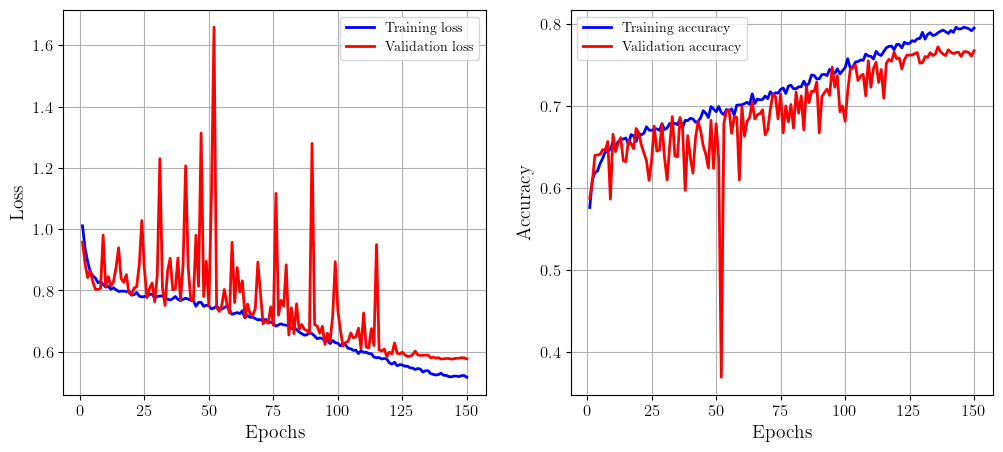

In [183]:
epochs = np.arange(1, 151)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#ax[0].scatter(epochs, loss_train, c='blue', s=30, edgecolor='black', label='Training loss')
ax[0].plot(epochs, loss_train, c='blue', linewidth=2, label='Training loss')
#ax[0].scatter(epochs, loss_valid, c='red', s=30, edgecolor='black', label='Validation loss')
ax[0].plot(epochs, loss_valid, c='red', linewidth=2, label='Validation loss')
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)

#ax[1].scatter(epochs, acc_train, c='blue', s=30, edgecolor='black', label='Training accuracy')
ax[1].plot(epochs, acc_train, c='blue', linewidth=2, label='Training accuracy')
#ax[1].scatter(epochs, acc_valid, c='red', s=30, edgecolor='black', label='Validation accuracy')
ax[1].plot(epochs, acc_valid, c='red', linewidth=2, label='Validation accuracy')
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
plt.savefig('./../results/history_adam_optim_alexnet.png', dpi=300, bbox_inches='tight')
plt.show()

In [185]:
# Saving model

#torch.save(model.state_dict(), './../saved/afibclass_adamoptim_alexnet.pth')

However, the accuracy score is not always the best predictor of performance for classification tasks. Hence, it is important to assess other metrics such as precision, recall and the $F_1$ scores of the different classes. First, the confusion matrix is calculated and plotted as a heatmap.

In [193]:
@torch.no_grad()
def get_confusion_matrix(valid_dl, model):
    # Defining a function for calculating the confusion matrix
    # Require the total number of true and prediction labels in each category

    all_preds = torch.Tensor([])

    for image, label in valid_dl:
        image, label = image.to(device), label.to(device)
        output = model(image)

        all_preds = torch.cat((all_preds, output.data), dim=0) # vertically stacks all outputs from iterations

    '''
    Converting the PyTorch tensors into numpy arrays
    '''
    all_preds = torch.max(all_preds, dim=1).indices.numpy()
    all_labels = label_list.iloc[idx_test, 2].to_numpy()
    
    return confusion_matrix(all_labels, all_preds)

CM = get_confusion_matrix(valid_dl, model)

print(CM)

[[ 69  32  39   5]
 [  8 904  73  12]
 [ 33 168 294  12]
 [  2   9   3  43]]


Since the train/test split was not stratified, it can be seen that the validation set is over represented by normal rhythm examples, on which it performs very well. Interestingly, a significant number of 'Normal' rhythms are classified as 'Other/Unclassified', which might arise from inherent similarities between them.

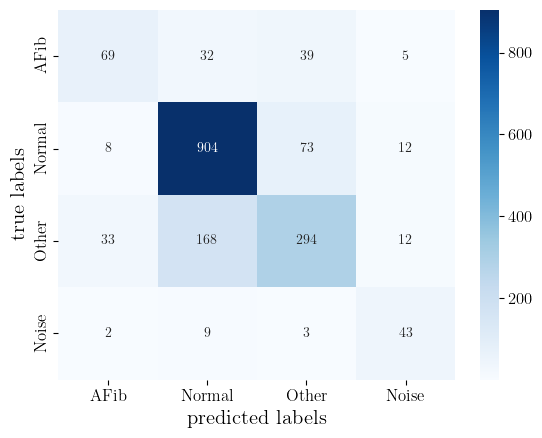

In [205]:
class_labels = ['AFib', 'Normal', 'Other', 'Noise']

sns.heatmap(CM, annot=True, fmt='.3g', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel(r'predicted labels', fontsize=15)
plt.ylabel(r'true labels', fontsize=15)
#plt.savefig('./../saved/CM_adam_optim_alexnet.png', dpi=300, bbox_inches='tight')
plt.show()

For a multiclass dataset, the precision and recall values can be best calculated using the confusion matrix. In a confusion matrix, the $y$-axis represents the true labels while the $x$ represents the predictions. Let $C_{ij}$ represent the elements of the confusion matrix. Then
$$ \text{Precision}_i = \frac{C_{ii}}{\sum_{i} C_{ij}},\;\;\;\;\; \text{Recall}_i = \frac{C_{ii}}{\sum_{j}C_{ij}} $$
where $i$ is the class label.

In [206]:
def F1_score(CM, class_label):
    '''
    This function returns the F1 score associated with a particular class label.
    0 - AFib, 1 - Normal, 2 - Other, 3 - Noise
    '''
    keys = {
        'AFib'   : 0,
        'Normal' : 1,
        'Other'  : 2,
        'Noise'  : 3
    }
    key = keys[class_label]

    precision = CM[key, key] / CM[:, key].sum()
    recall = CM[key, key] / CM[key, :].sum()
    F1_score = 2*precision*recall / (precision + recall)

    return F1_score 

F1_AFib = F1_score(CM, 'AFib')
F1_Normal = F1_score(CM, 'Normal')
F1_Other = F1_score(CM, 'Other')
F1_Noise = F1_score(CM, 'Noise')
F1_overall = 0.25*(F1_AFib + F1_Normal + F1_Other + F1_Noise)
accuracy_score = np.trace(CM)/np.sum(CM)

print(f'F1 score for AFib: {F1_AFib}')
print(f'F1 score for Normal: {F1_Normal}')
print(f'F1 score for Other: {F1_Other}')
print(f'F1 score for Noise: {F1_Noise}')

print(f'Overall F1 score: {F1_overall}')
print(f'Accuracy score: {accuracy_score}')

F1 score for AFib: 0.5369649805447471
F1 score for Normal: 0.8568720379146919
F1 score for Other: 0.6419213973799126
F1 score for Noise: 0.6666666666666666
Overall F1 score: 0.6756062706265045
Accuracy score: 0.7678780773739742
